### Libraries

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.feature_selection import RFE

In [2]:
# Load the new voorspelers file with semicolon separator
voorspellers_df = pd.read_csv('../Export/Voorspellers.csv', delimiter=';')

# Load the uitkomstmaat data_clean_cleanset
uitkomstmaat_df = pd.read_csv('../Export/uitkomstmaat.csv', delimiter=';')
uitkomstmaat_vars = uitkomstmaat_df[["patientnummer", "T0", "T5"]]

ML_df = pd.merge(voorspellers_df, uitkomstmaat_vars, left_on='Participant Id', right_on='patientnummer', how='inner')
ML_df.drop(columns=['Participant Id', 'patientnummer'], inplace=True)
ML_df['T5_recovered'] = ML_df['T5'] < 45
ML_df['T5_recovered'].sum()

44

In [3]:
# Calculate the number of people below 0.9 and above 0.9
below_count = ML_df[ML_df['T5_recovered'] < 1].shape[0]
above_count = ML_df[ML_df['T5_recovered'] >= 1].shape[0]

print(f"Number of people with T5_recovered below 1: {below_count}")
print(f"Number of people with T5_recovered 1 or above: {above_count}")

Number of people with T5_recovered below 1: 119
Number of people with T5_recovered 1 or above: 44


<AxesSubplot:>

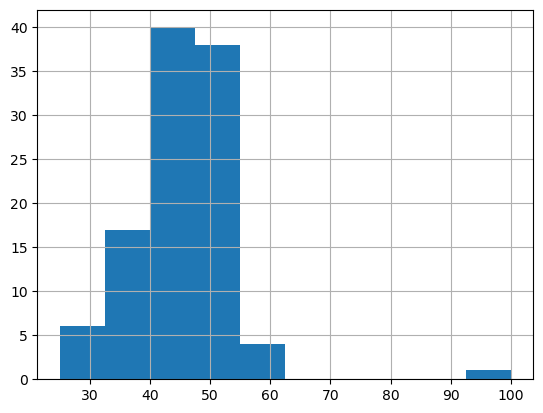

In [4]:
ML_df['T5'].hist()

### Imputing Data

In [5]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np

# Assume ML_df is your DataFrame
# data_clean is data met Imputation
# data is data zonder imputation
data_clean = ML_df.copy()
data = ML_df.copy()

# Identify columns
continuous_columns = [
    'T0_age', 'T0_BMI', 'T0_BIA_VVM_kg', 'T0_BIA_vetmassa_kg', 
    'Time_pretreat_OK', 'OK_Duration_min', 'Length_of_stay', 
    'T0_30SCST', 'T0_fatigue', 'T0_protein_perc', 'T0_kcal_perc', 
    'T0_CT_SMI', 'T0_CT_SMRA', 't0_gses_totaal_score', 
    'T0_participation_ability', 'T0_participation_satisfaction', 
    't0_EQ_5D_5L_beschrijvend-systeem_score', 'T0_pain', 'T0'
]

categorical_columns = [
    'T0_VVMI_per', 'Education', 'household', 'T0_Tumorsize', 
    'T0_diseaseburden_cat', 'T0_selfcare', 'T0_Locusofcontrol_cat',
    'T0_socialsupport_cat', 'T0_coping_cat', 'AMEXO_8_day1', 
    'AMEXO_9_day2', 'AMEXO_10_day3', 'T0_sondevoeding', 'T0_protein_cat',
    'T0_kcal_cat', 'T0_ASM_low', 'T0_anxiety_cat', 'T0_depression_cat'
]

# Remove rows with missing values in T5
if 'T5_relative' in data_clean.columns:
    data_clean = data_clean.dropna(subset=['T5_relative'])

# Remove rows where T5 > 80
if 'T5' in data_clean.columns:
    data_clean = data_clean[data_clean['T5'] <= 80]

# Initialize the SimpleImputer with median strategy for continuous variables
median_imputer = SimpleImputer(strategy='median')

# Apply median imputation excluding 'T5'
existing_continuous_columns = [col for col in continuous_columns if col in data_clean.columns]
if existing_continuous_columns:
    data_clean[existing_continuous_columns] = median_imputer.fit_transform(data_clean[existing_continuous_columns])

# Initialize the SimpleImputer with mode strategy for categorical variables
mode_imputer = SimpleImputer(strategy='most_frequent')

# Apply mode imputation to categorical columns
existing_categorical_columns = [col for col in categorical_columns if col in data_clean.columns]
if existing_categorical_columns:
    data_clean[existing_categorical_columns] = mode_imputer.fit_transform(data_clean[existing_categorical_columns])

# Fill missing values for specific columns with 0
for col in ['Complications_CCI', 'readmission_30days', 'Time_OK_posttreat']:
    if col in data_clean.columns:
        data_clean[col] = data_clean[col].fillna(0)

# Verify no remaining missing values except for T5
missing_values_final_check = data_clean.isnull().sum()
data_clean

# Output the missing values check
missing_values_final_check.sum()


c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


0

### Libraries

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import RFE
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_clean is already defined and clean

# Select the features and target variable
X = data_clean.drop(columns=['T5', 'T5_recovered'])
y = data_clean['T5_recovered']

# Maak een train/test split met 70% train en 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Functions

In [7]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, specificity, f1

def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test, metrics):
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
    metrics['Model'].append(model_name)
    metrics['Dataset'].append('Test')
    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['Specificity'].append(specificity)
    metrics['F1'].append(f1)
    return model, y_test_pred

def plot_conf_matrix(model, X_test, y_test, model_name):
    if isinstance(model, NullModel):
        cm = confusion_matrix(y_test, model.predict(X_test))
        fig, ax = plt.subplots()
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set(xlabel='Predicted', ylabel='True', title=f'Confusion Matrix for {model_name} (Test)')
        ax.set_xticklabels(['Not Recovered', 'Recovered'])
        ax.set_yticklabels(['Not Recovered', 'Recovered'])
        plt.show()
    else:
        plot_confusion_matrix(model, X_test, y_test, display_labels=['Not Recovered', 'Recovered'])
        plt.title(f'Confusion Matrix for {model_name} (Test)')
        plt.show()

class NullModel:
    def fit(self, X, y):
        self.mode = y.mode()[0]
    def predict(self, X):
        return np.full(len(X), self.mode)
    
def plot_feature_importance(model, model_name, X):
    if model_name == 'Logistic Regression':
        coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
        coefficients['Direction'] = coefficients['Coefficient'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
        coefficients = coefficients.sort_values(by='Coefficient', key=abs, ascending=False)
        print(coefficients)

        plt.figure(figsize=(10, 8))
        sns.barplot(data=coefficients, x='Coefficient', y='Feature', hue='Direction', dodge=False)
        plt.title('Feature Importance and Direction for Logistic Regression')
        plt.show()

    elif model_name == 'XGBoost':
        xgb_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
        xgb_importances = xgb_importances.sort_values(by='Importance', ascending=False)
        print(xgb_importances)

        plt.figure(figsize=(10, 8))
        sns.barplot(data=xgb_importances, x='Importance', y='Feature')
        plt.title('Feature Importance for XGBoost')
        plt.show()

# Forward feature selection function
def forward_feature_selection(model, X_train, y_train, X_test, y_test):
    initial_features = []
    best_features = []
    best_score = 0
    current_score = 0

    while True:
        scores = []
        for feature in X_train.columns:
            if feature in initial_features:
                continue
            selected_features = initial_features + [feature]
            model.fit(X_train[selected_features], y_train)
            y_pred = model.predict(X_test[selected_features])
            accuracy = accuracy_score(y_test, y_pred)
            scores.append((accuracy, feature))

        scores.sort(reverse=True)
        current_score, best_feature = scores[0]

        if current_score > best_score:
            best_score = current_score
            best_features.append(best_feature)
            initial_features.append(best_feature)
        else:
            break

    return best_features


### Simple Train / Test Split
- Hier pak ik 4 modellen, Logistic Regression, Decision tree, XGBoost en Nul model (mode) en ik train deze modellen op de test en kijk naar de nauwkeurigheid op de test set. Dit is nog zonder parameter optimalisatie. Alle modellen. Inclusief de lasso regressie lijken het slechter te doen dan de null model.
- Daarna heb ik een RFE benadering geprobeerd met dezelfde modellen
- Daarna heb ik een forward feature selection gebprobeerd

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


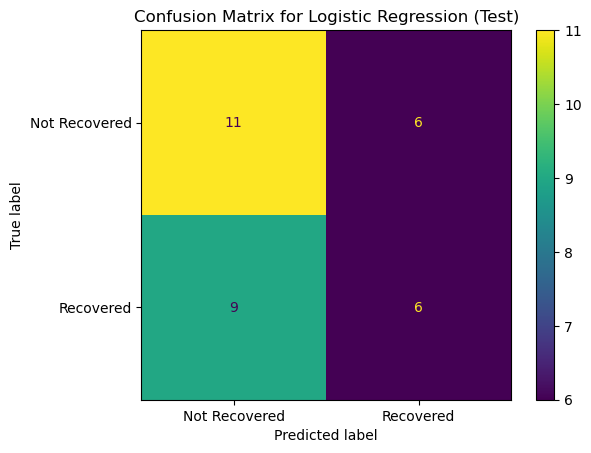

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


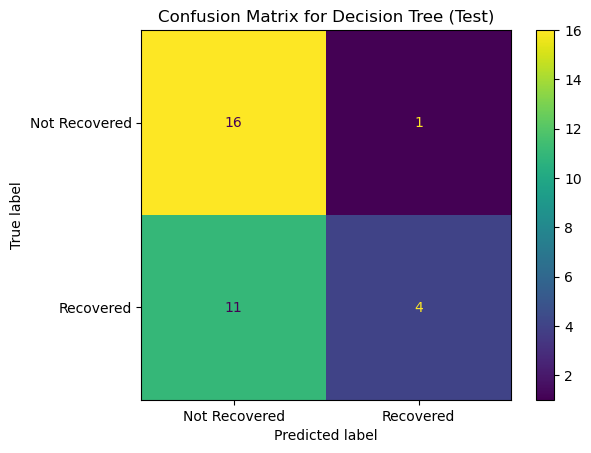

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


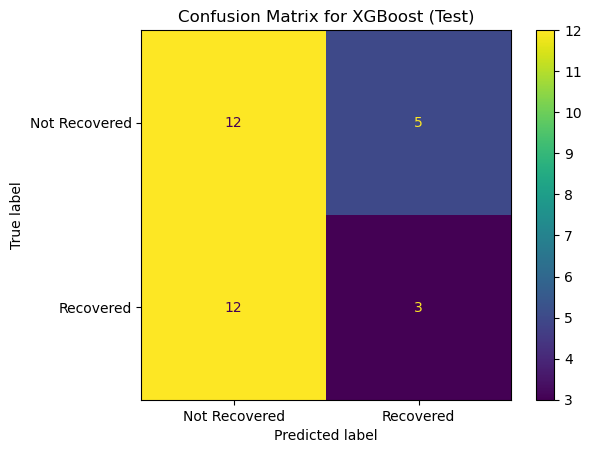

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


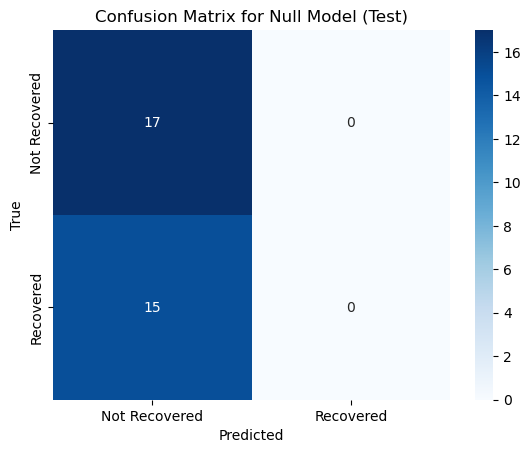

                 Model Dataset  Accuracy  Precision    Recall  Specificity  \
0  Logistic Regression    Test   0.53125      0.500  0.400000     0.647059   
1        Decision Tree    Test   0.62500      0.800  0.266667     0.941176   
2              XGBoost    Test   0.46875      0.375  0.200000     0.705882   
3           Null Model    Test   0.53125      0.000  0.000000     1.000000   

         F1  
0  0.444444  
1  0.400000  
2  0.260870  
3  0.000000  


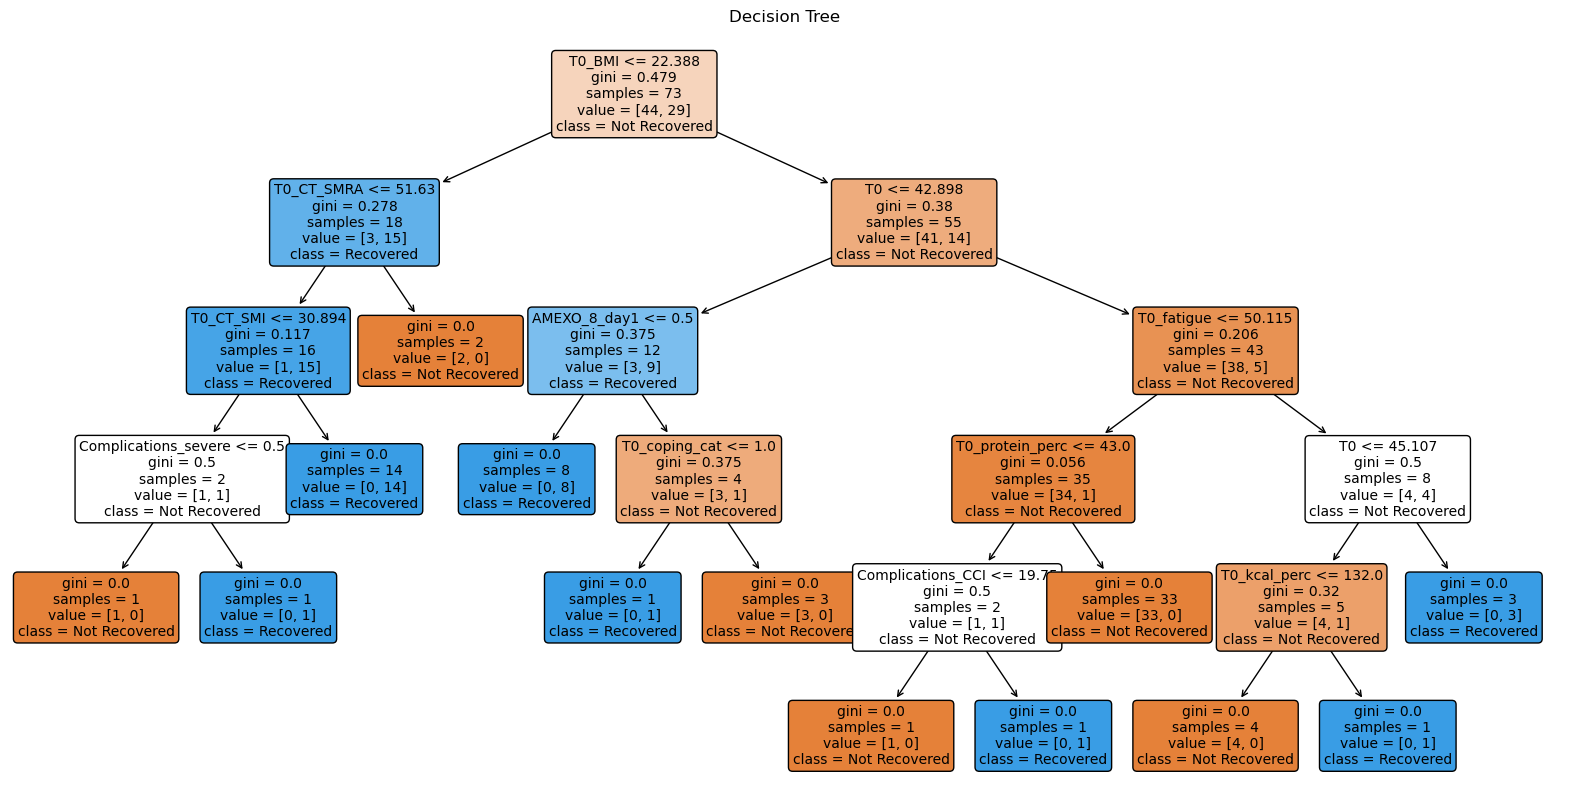

In [9]:
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
log_reg, y_test_pred = train_and_evaluate(log_reg, 'Logistic Regression', X_train, y_train, X_test, y_test, metrics)
plot_conf_matrix(log_reg, X_test, y_test, 'Logistic Regression')

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=15)
tree_model, y_test_pred = train_and_evaluate(tree_model, 'Decision Tree', X_train, y_train, X_test, y_test, metrics)
plot_conf_matrix(tree_model, X_test, y_test, 'Decision Tree')

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model, y_test_pred = train_and_evaluate(xgb_model, 'XGBoost', X_train, y_train, X_test, y_test, metrics)
plot_conf_matrix(xgb_model, X_test, y_test, 'XGBoost')

# Null Model
null_model = NullModel()
null_model.fit(X_train, y_train)
null_model, y_test_pred = train_and_evaluate(null_model, 'Null Model', X_train, y_train, X_test, y_test, metrics)
plot_conf_matrix(null_model, X_test, y_test, 'Null Model')

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=X.columns, class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()


c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


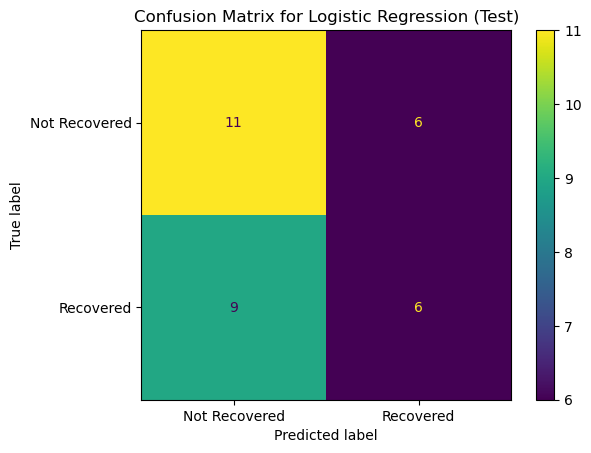

                                   Feature  Coefficient Direction
33                              T0_eetlust    -1.203048  Negative
42                       T0_depression_cat    -0.858794  Negative
4                                Education     0.796588  Positive
24                        OK_posttreatment     0.767874  Positive
9                     T0_diseaseburden_cat     0.634559  Positive
36                              T0_ASM_low     0.599664  Positive
13                           T0_coping_cat    -0.593662  Negative
27                               T0_30SCST    -0.580665  Negative
8                                   T0_ASA    -0.579782  Negative
10                             T0_selfcare     0.538235  Positive
14                         OK_pretreatment     0.514657  Positive
20                    Complications_severe    -0.495544  Negative
43                                      T0    -0.492033  Negative
28                                 T0_pain     0.422750  Positive
23        

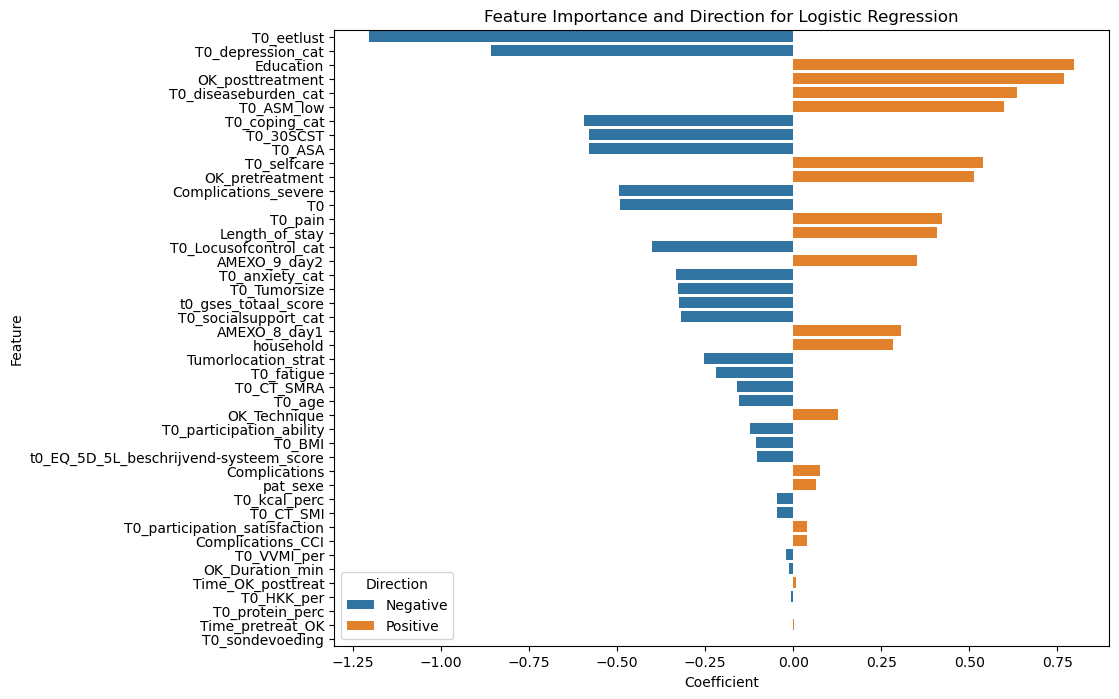

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


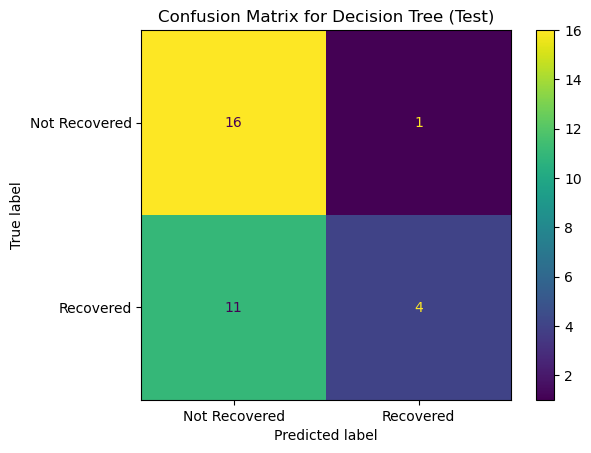

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


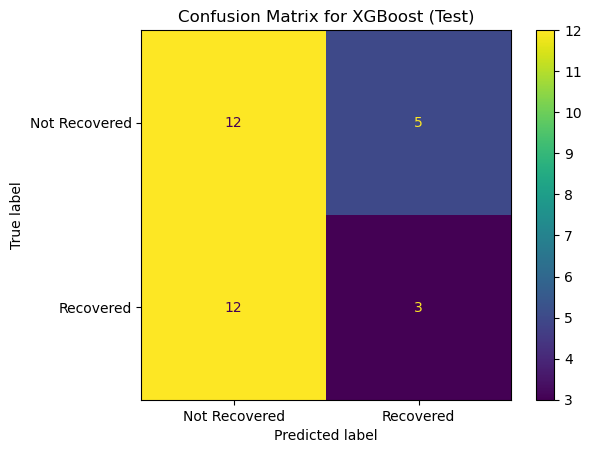

                                   Feature  Importance
29                              T0_fatigue    0.148809
43                                      T0    0.107308
2                                   T0_BMI    0.091717
25                       Time_OK_posttreat    0.065005
23                          Length_of_stay    0.063313
15                        Time_pretreat_OK    0.058458
37                    t0_gses_totaal_score    0.049122
31                         T0_protein_perc    0.042512
21                            AMEXO_8_day1    0.040667
4                                Education    0.039978
0                                 pat_sexe    0.037612
13                           T0_coping_cat    0.035265
19                       Complications_CCI    0.032087
33                              T0_eetlust    0.026076
34                               T0_CT_SMI    0.022931
17                         OK_Duration_min    0.022563
40  t0_EQ_5D_5L_beschrijvend-systeem_score    0.018757
35        

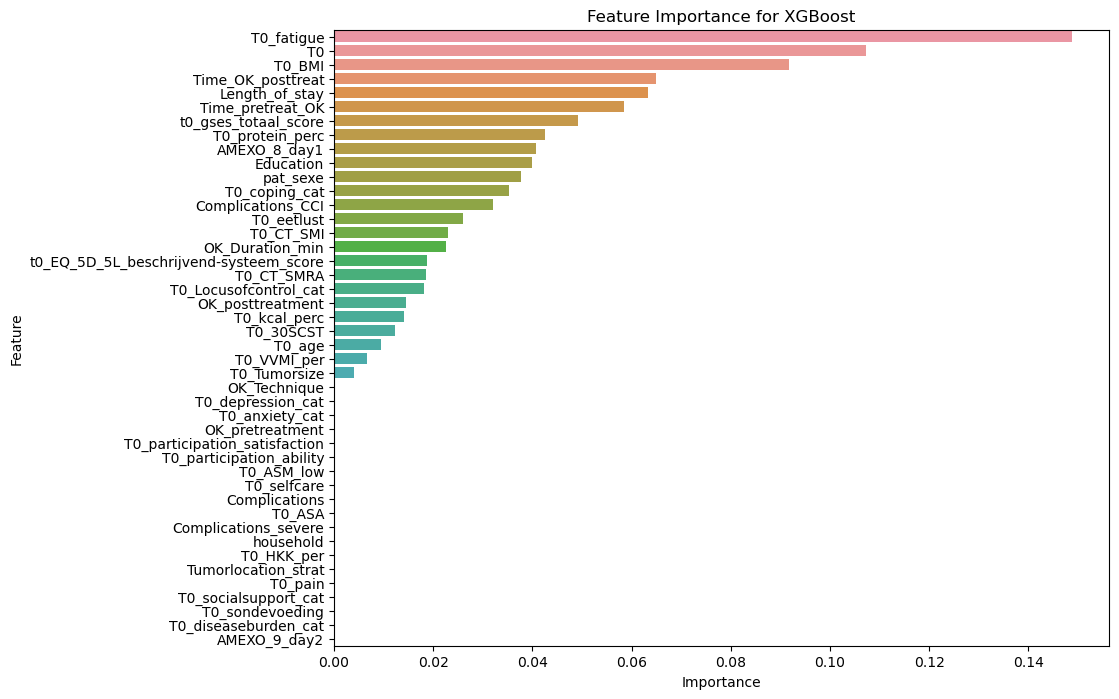

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


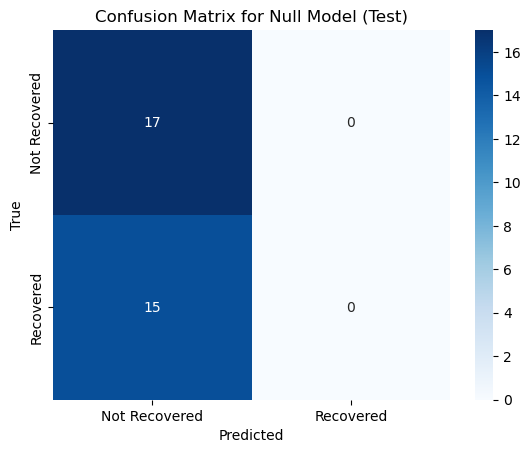

                 Model Dataset  Accuracy  Precision    Recall  Specificity  \
0  Logistic Regression    Test   0.53125      0.500  0.400000     0.647059   
1        Decision Tree    Test   0.62500      0.800  0.266667     0.941176   
2              XGBoost    Test   0.46875      0.375  0.200000     0.705882   
3           Null Model    Test   0.53125      0.000  0.000000     1.000000   

         F1  
0  0.444444  
1  0.400000  
2  0.260870  
3  0.000000  


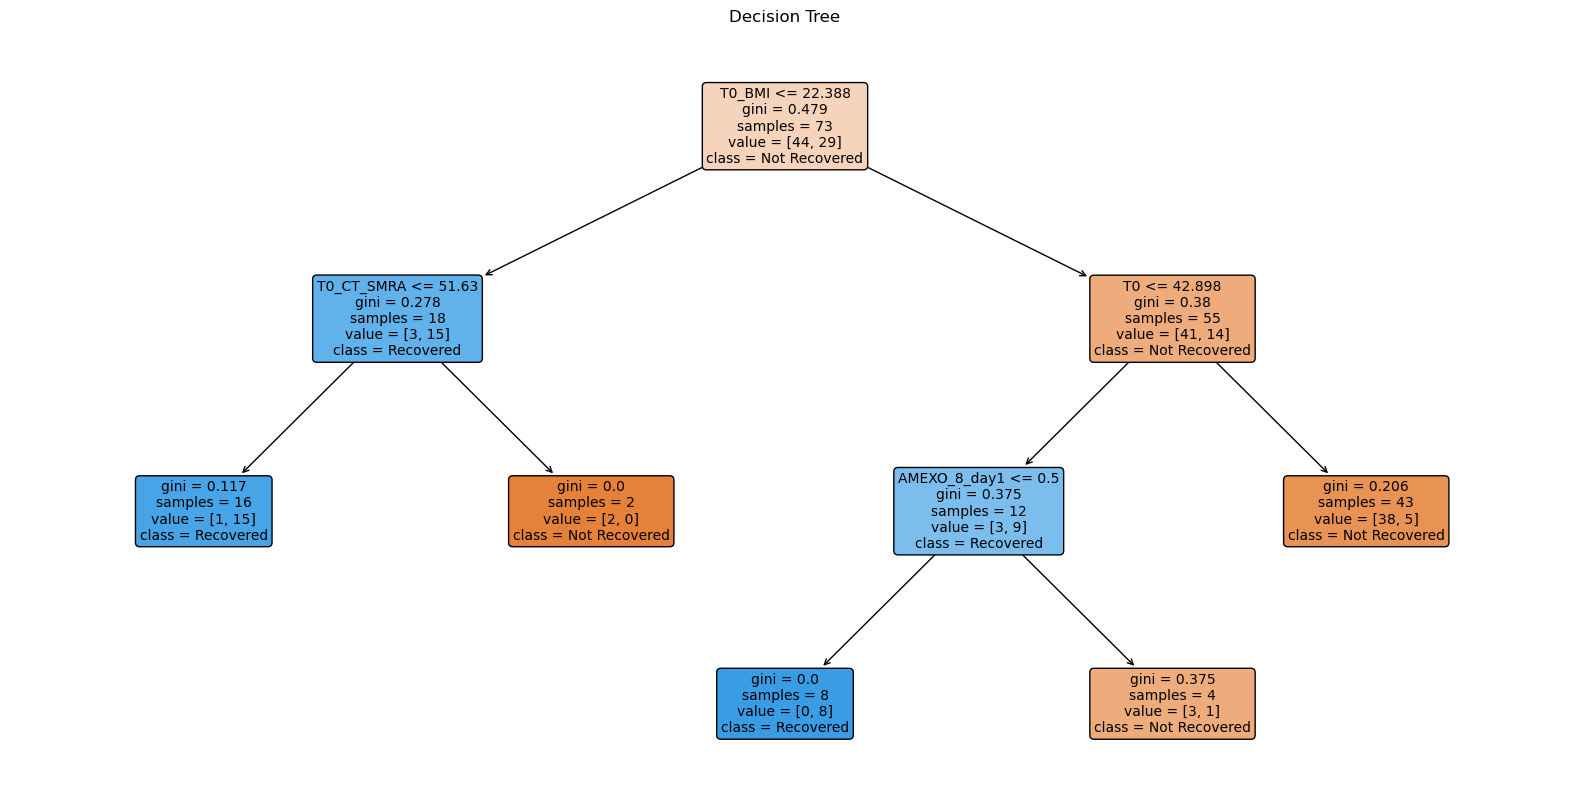

In [10]:
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
log_reg, y_test_pred = train_and_evaluate(log_reg, 'Logistic Regression', X_train, y_train, X_test, y_test, metrics)
plot_conf_matrix(log_reg, X_test, y_test, 'Logistic Regression')
plot_feature_importance(log_reg, 'Logistic Regression', X)

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=5)
tree_model, y_test_pred = train_and_evaluate(tree_model, 'Decision Tree', X_train, y_train, X_test, y_test, metrics)
plot_conf_matrix(tree_model, X_test, y_test, 'Decision Tree')

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model, y_test_pred = train_and_evaluate(xgb_model, 'XGBoost', X_train, y_train, X_test, y_test, metrics)
plot_conf_matrix(xgb_model, X_test, y_test, 'XGBoost')
plot_feature_importance(xgb_model, 'XGBoost', X)

# Null Model
null_model = NullModel()
null_model.fit(X_train, y_train)
null_model, y_test_pred = train_and_evaluate(null_model, 'Null Model', X_train, y_train, X_test, y_test, metrics)
plot_conf_matrix(null_model, X_test, y_test, 'Null Model')

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()


c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


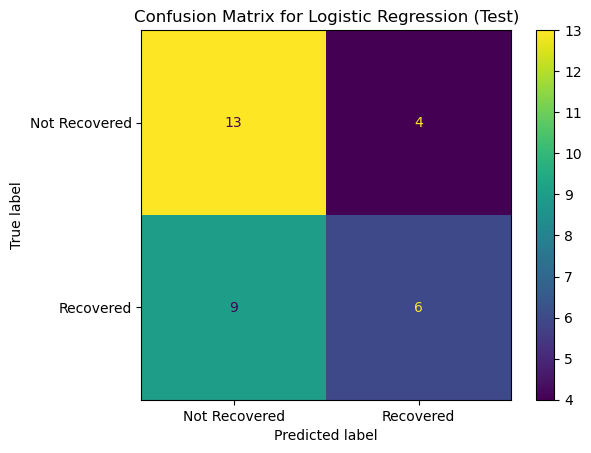

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


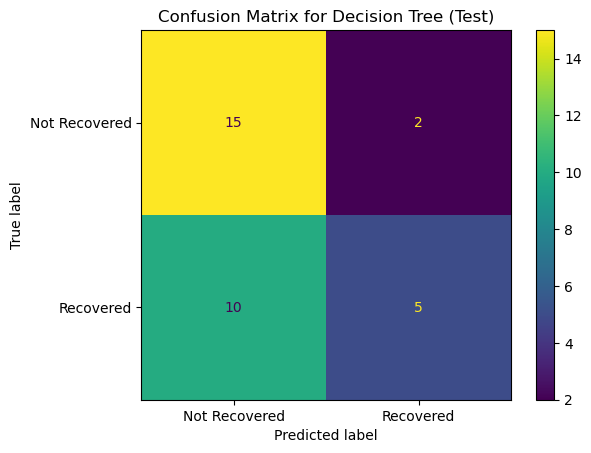

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


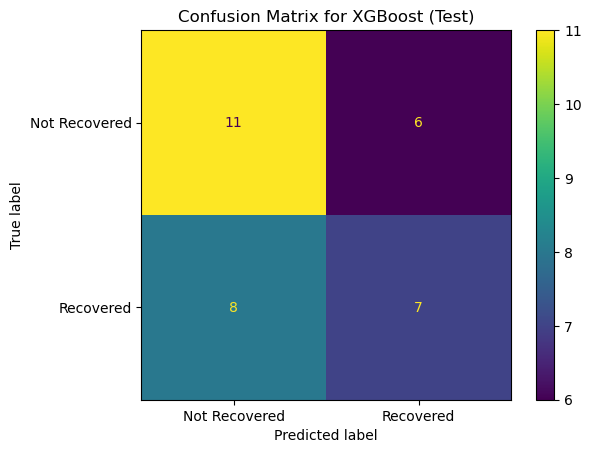

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


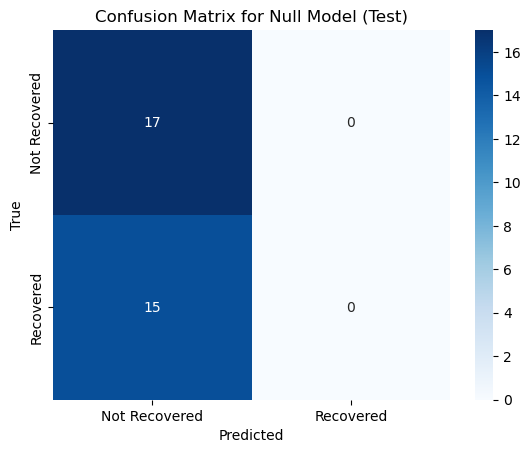

                 Model Dataset  Accuracy  Precision    Recall  Specificity  \
0  Logistic Regression    Test   0.59375   0.600000  0.400000     0.764706   
1        Decision Tree    Test   0.62500   0.714286  0.333333     0.882353   
2              XGBoost    Test   0.56250   0.538462  0.466667     0.647059   
3           Null Model    Test   0.53125   0.000000  0.000000     1.000000   

         F1  
0  0.480000  
1  0.454545  
2  0.500000  
3  0.000000  


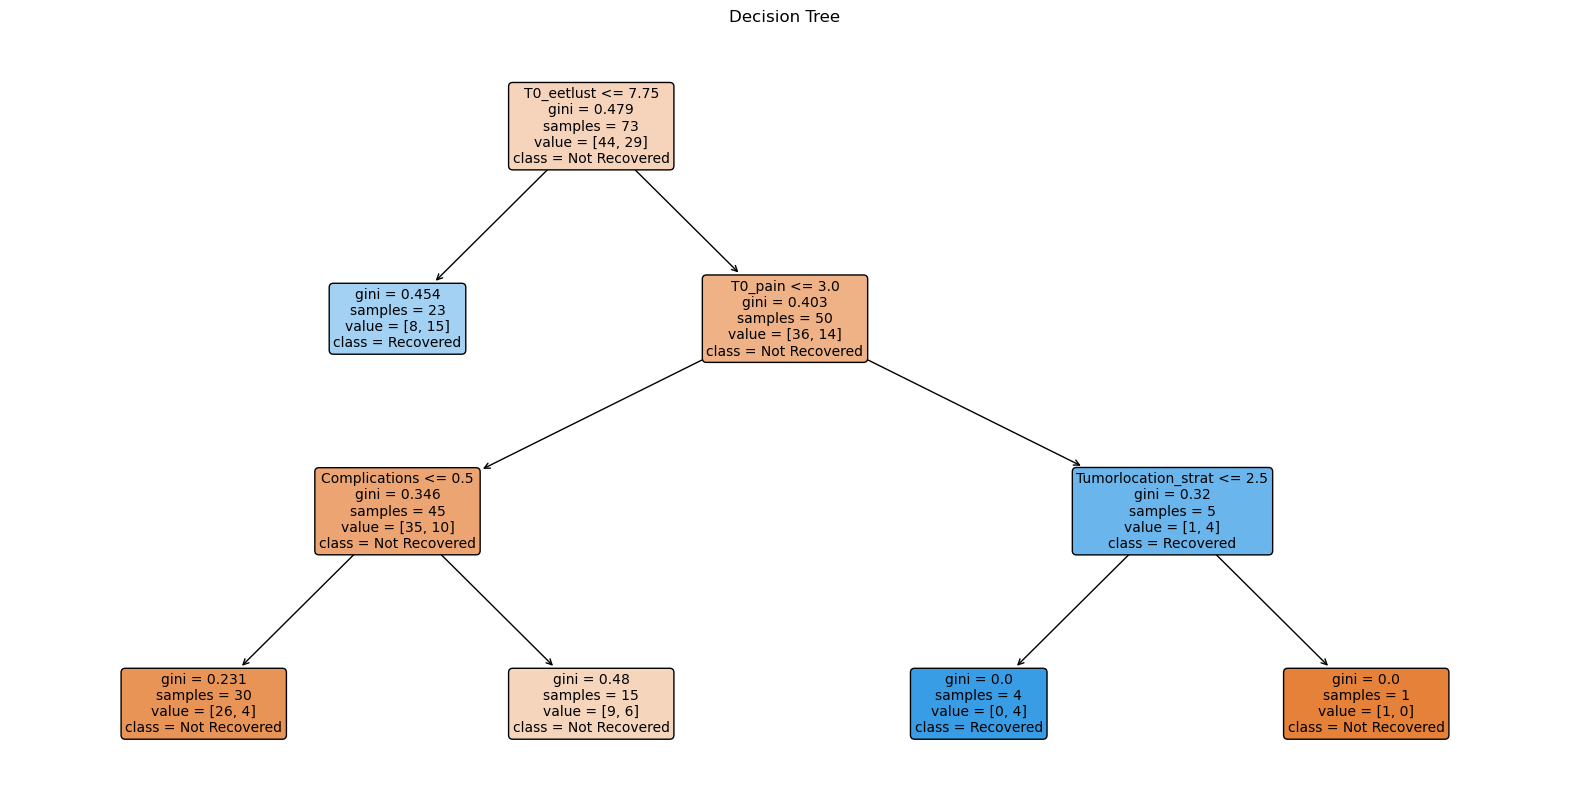

In [11]:
# Select the features and target variable
X = data_clean.drop(columns=['T5',  'T5_recovered'])
y = data_clean['T5_recovered']

# Make a train/test split with 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Recursive Feature Elimination (RFE) with Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
rfe = RFE(log_reg, n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Initialize and train models using the reduced feature set
log_reg = LogisticRegression(max_iter=10000)
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=5)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
null_model = NullModel()

# Evaluate models
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Train and evaluate Logistic Regression
log_reg, y_test_pred = train_and_evaluate(log_reg, 'Logistic Regression', X_train_rfe, y_train, X_test_rfe, y_test, metrics)
plot_conf_matrix(log_reg, X_test_rfe, y_test, 'Logistic Regression')

# Train and evaluate Decision Tree
tree_model, y_test_pred = train_and_evaluate(tree_model, 'Decision Tree', X_train_rfe, y_train, X_test_rfe, y_test, metrics)
plot_conf_matrix(tree_model, X_test_rfe, y_test, 'Decision Tree')

# Train and evaluate XGBoost
xgb_model, y_test_pred = train_and_evaluate(xgb_model, 'XGBoost', X_train_rfe, y_train, X_test_rfe, y_test, metrics)
plot_conf_matrix(xgb_model, X_test_rfe, y_test, 'XGBoost')

# Train and evaluate Null Model
null_model, y_test_pred = train_and_evaluate(null_model, 'Null Model', X_train_rfe, y_train, X_test_rfe, y_test, metrics)
plot_conf_matrix(null_model, X_test_rfe, y_test, 'Null Model')

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=X.columns[rfe.get_support()], class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()


### Meest nauwkeurige benadering

Best Parameters for Decision Tree: {'ccp_alpha': 0.01, 'max_features_usage': 2, 'max_leaf_nodes': 100}
                 Model  Accuracy  Precision    Recall  Specificity        F1
0  Logistic Regression   0.81250   0.909091  0.666667     0.941176  0.769231
1        Decision Tree   0.62500   0.800000  0.266667     0.941176  0.400000
2              XGBoost   0.78125   0.833333  0.666667     0.882353  0.740741


c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 800x600 with 0 Axes>

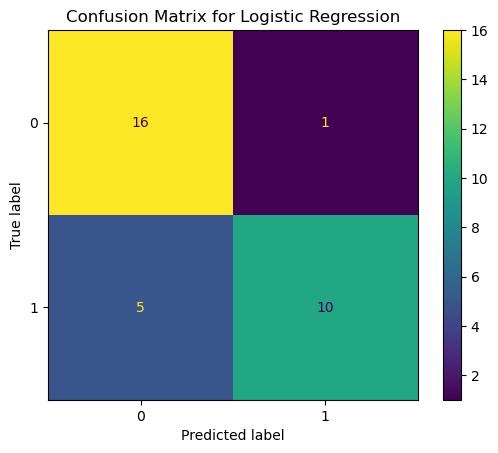

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 800x600 with 0 Axes>

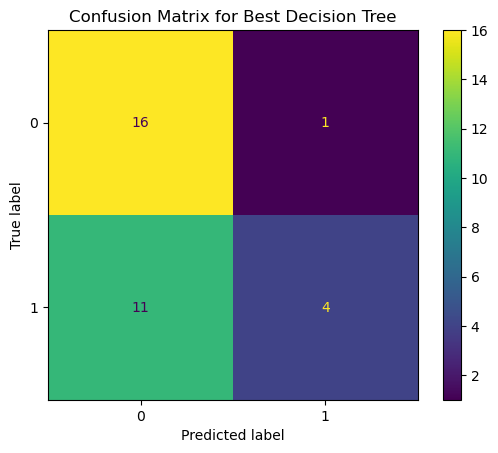

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 800x600 with 0 Axes>

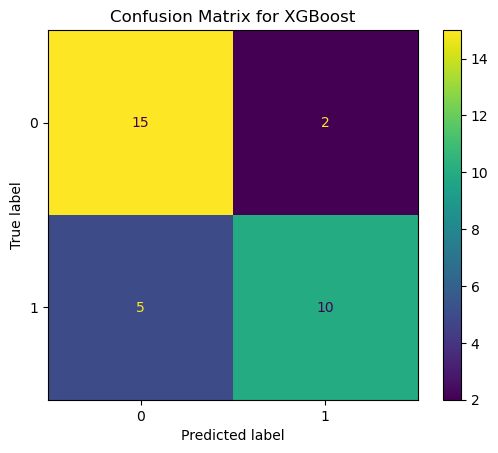

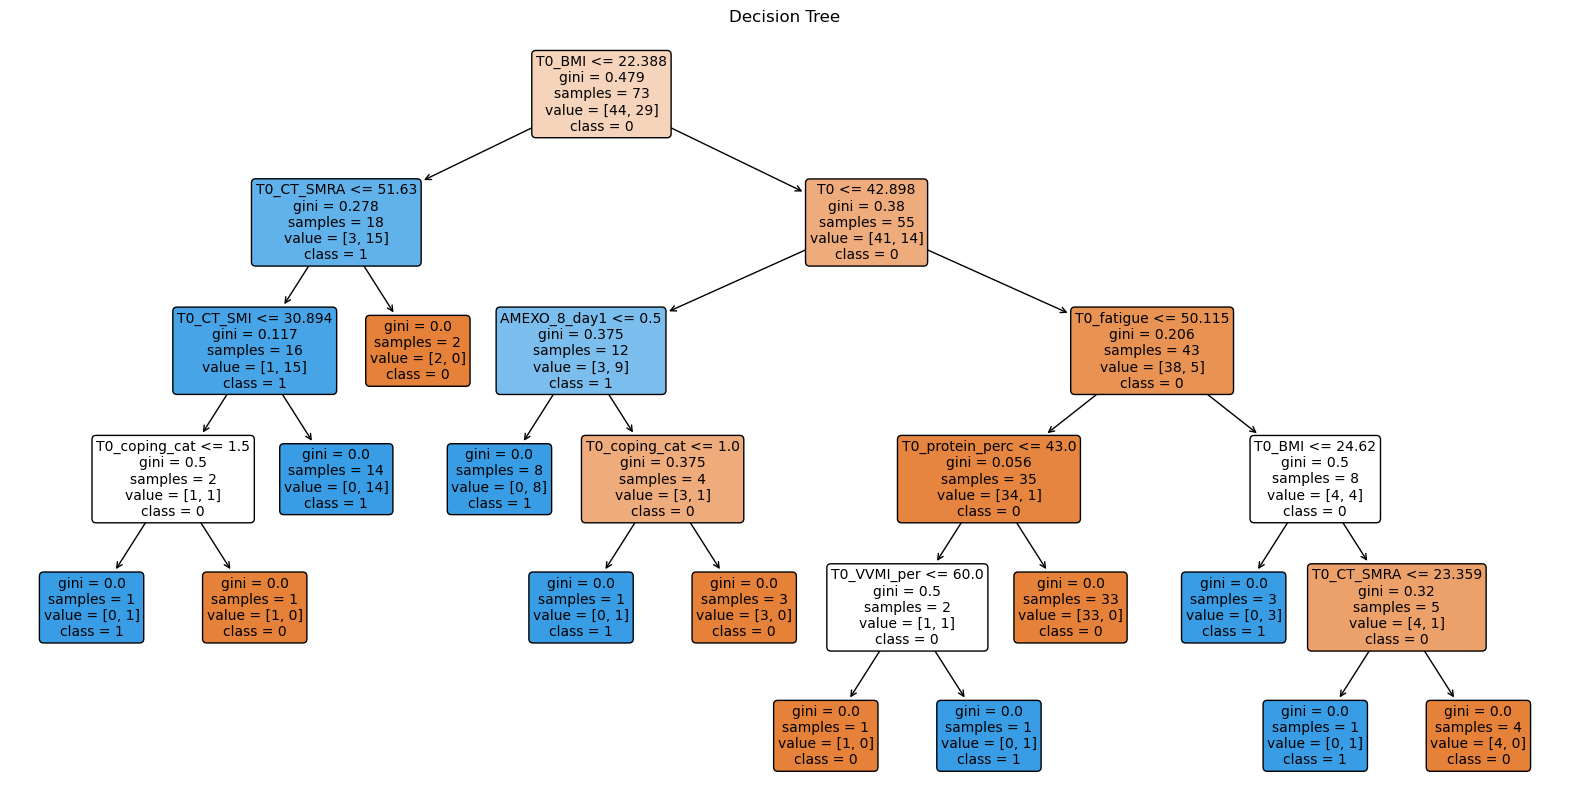

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_clean is already defined and clean
# Encode target if it's categorical
le = LabelEncoder()
data_clean['T5_recovered'] = le.fit_transform(data_clean['T5_recovered'])

# Select features and target variable
X = data_clean.drop(columns=['T5', 'T5_recovered'])
y = data_clean['T5_recovered']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Recursive Feature Elimination (RFE) with Logistic Regression
from sklearn.feature_selection import RFE
log_reg = LogisticRegression(max_iter=10000)
rfe = RFE(log_reg, n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Forward Feature Selection Function
def forward_feature_selection(model, X_train, y_train, X_test, y_test):
    initial_features = []
    best_features = []
    best_score = 0
    current_score = 0

    while True:
        scores = []
        for feature in X_train.columns:
            if feature in initial_features:
                continue
            selected_features = initial_features + [feature]
            model.fit(X_train[selected_features], y_train)
            y_pred = model.predict(X_test[selected_features])
            accuracy = accuracy_score(y_test, y_pred)
            scores.append((accuracy, feature))

        scores.sort(reverse=True)
        current_score, best_feature = scores[0]

        if current_score > best_score:
            best_score = current_score
            best_features.append(best_feature)
            initial_features.append(best_feature)
        else:
            break

    return best_features

# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
best_features_log_reg = forward_feature_selection(log_reg, X_train, y_train, X_test, y_test)

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
best_features_xgb = forward_feature_selection(xgb_model, X_train, y_train, X_test, y_test)

# Custom Decision Tree Classifier with Feature Constraint
class CustomDecisionTreeClassifier(DecisionTreeClassifier):
    def __init__(self, max_leaf_nodes=None, ccp_alpha=0.0, max_features_usage=2, **kwargs):
        super().__init__(max_leaf_nodes=max_leaf_nodes, ccp_alpha=ccp_alpha, **kwargs)
        self.max_features_usage = max_features_usage
    
    def _fit(self, X, y, sample_weight=None):
        super()._fit(X, y, sample_weight)
        self._check_feature_usage()
    
    def _check_feature_usage(self):
        feature_usage = {}
        def count_usage(node):
            if node.feature is not None:
                feature_usage[node.feature] = feature_usage.get(node.feature, 0) + 1
            if node.left:
                count_usage(node.left)
            if node.right:
                count_usage(node.right)

        count_usage(self.tree_)
        for feature, usage in feature_usage.items():
            if usage > self.max_features_usage:
                raise ValueError(f"Feature {feature} used more than {self.max_features_usage} times")

# Hyperparameter Optimization for Custom Decision Tree
param_grid = {
    'max_leaf_nodes': [10, 20, 50, 100, 200],
    'ccp_alpha': [0.0, 0.01, 0.1, 0.5],
    'max_features_usage': [2]  # Not used directly in GridSearchCV but included for custom class
}

custom_tree_model = CustomDecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=custom_tree_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_tree_model = grid_search.best_estimator_

print("Best Parameters for Decision Tree:", best_params)

# Evaluate the Best Decision Tree Model
y_test_pred_tree = best_tree_model.predict(X_test)

# Metrics for Decision Tree
accuracy_tree = accuracy_score(y_test, y_test_pred_tree)
precision_tree = precision_score(y_test, y_test_pred_tree)
recall_tree = recall_score(y_test, y_test_pred_tree)
f1_tree = f1_score(y_test, y_test_pred_tree)
tn_tree, fp_tree, fn_tree, tp_tree = confusion_matrix(y_test, y_test_pred_tree).ravel()
specificity_tree = tn_tree / (tn_tree + fp_tree)

# Metrics for Logistic Regression
log_reg.fit(X_train[best_features_log_reg], y_train)
y_test_pred_log_reg = log_reg.predict(X_test[best_features_log_reg])
accuracy_log_reg, precision_log_reg, recall_log_reg, specificity_log_reg, f1_log_reg = calculate_metrics(y_test, y_test_pred_log_reg)

# Metrics for XGBoost
xgb_model.fit(X_train[best_features_xgb], y_train)
y_test_pred_xgb = xgb_model.predict(X_test[best_features_xgb])
accuracy_xgb, precision_xgb, recall_xgb, specificity_xgb, f1_xgb = calculate_metrics(y_test, y_test_pred_xgb)

# Collect metrics
metrics = {
    'Model': ['Logistic Regression', 'Decision Tree', 'XGBoost'],
    'Accuracy': [accuracy_log_reg, accuracy_tree, accuracy_xgb],
    'Precision': [precision_log_reg, precision_tree, precision_xgb],
    'Recall': [recall_log_reg, recall_tree, recall_xgb],
    'Specificity': [specificity_log_reg, specificity_tree, specificity_xgb],
    'F1': [f1_log_reg, f1_tree, f1_xgb]
}

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot confusion matrices for individual models
# Logistic Regression
plt.figure(figsize=(8, 6))
plot_confusion_matrix(log_reg, X_test[best_features_log_reg], y_test, display_labels=le.classes_)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Decision Tree
plt.figure(figsize=(8, 6))
plot_confusion_matrix(best_tree_model, X_test, y_test, display_labels=le.classes_)
plt.title('Confusion Matrix for Best Decision Tree')
plt.show()

# XGBoost
plt.figure(figsize=(8, 6))
plot_confusion_matrix(xgb_model, X_test[best_features_xgb], y_test, display_labels=le.classes_)
plt.title('Confusion Matrix for XGBoost')
plt.show()

# Plot the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(best_tree_model, feature_names=X.columns, class_names=[str(cls) for cls in le.classes_], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()


c:\Users\melmora\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Selected Features: ['T0_coping_cat', 'AMEXO_8_day1', 'AMEXO_9_day2', 'Length_of_stay', 'T0_pain']

Training Set Performance:
Accuracy: 0.7808219178082192
Precision: 0.8095238095238095
Recall: 0.5862068965517241
F1 Score: 0.68

Test Set Performance:
Accuracy: 0.5
Precision: 0.42857142857142855
Recall: 0.2
F1 Score: 0.27272727272727276


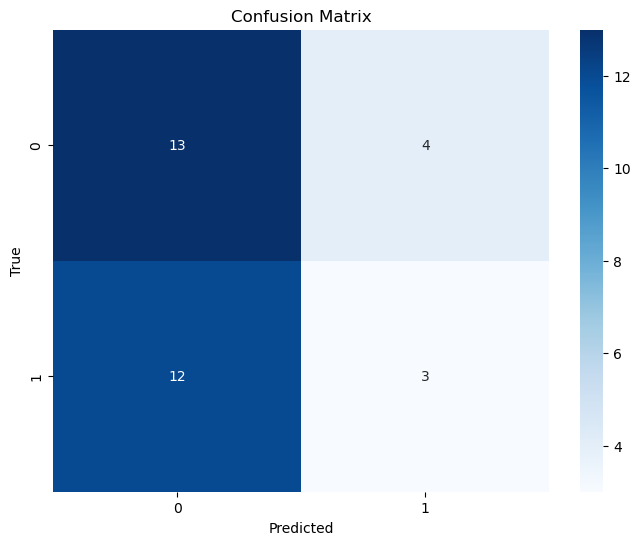

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming data_clean is already defined and clean
# Encode target if it's categorical
le = LabelEncoder()
data_clean['T5_recovered'] = le.fit_transform(data_clean['T5_recovered'])

# Select features and target variable
X = data_clean.drop(columns=['T5', 'T5_recovered'])
y = data_clean['T5_recovered']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Function to calculate VIF
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# Function to perform backward feature selection
def backward_feature_selection(X, y, significance_level=0.05):
    features = X.columns.tolist()
    while len(features) > 0:
        X_with_const = sm.add_constant(X[features])
        model = sm.Logit(y, X_with_const).fit(disp=0)
        p_values = model.pvalues.iloc[1:]  # Exclude the constant term
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break

    return features

# Remove collinear features based on VIF
def remove_collinear_features(X, threshold=5.0):
    while True:
        vif = calculate_vif(X)
        max_vif = vif["VIF"].max()
        if max_vif > threshold:
            removed_feature = vif.loc[vif["VIF"].idxmax(), "Feature"]
            X = X.drop(columns=[removed_feature])
        else:
            break
    return X

# Initial VIF check and removal
X_train_reduced = remove_collinear_features(X_train)

# Backward feature selection
selected_features = backward_feature_selection(X_train_reduced, y_train)

# Reduced datasets based on selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train a logistic regression model with the selected features
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_selected, y_train)

# Predict on the training set
y_train_pred = log_reg.predict(X_train_selected)

# Predict on the test set
y_test_pred = log_reg.predict(X_test_selected)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print the results
print("Selected Features:", selected_features)
print("\nTraining Set Performance:")
print("Accuracy:", train_accuracy)
print("Precision:", train_precision)
print("Recall:", train_recall)
print("F1 Score:", train_f1)

print("\nTest Set Performance:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


                                   Feature  Importance
43                                      T0    0.284206
2                                   T0_BMI    0.259910
35                              T0_CT_SMRA    0.089391
21                            AMEXO_8_day1    0.085815
29                              T0_fatigue    0.082793
34                               T0_CT_SMI    0.070797
33                              T0_eetlust    0.042908
23                          Length_of_stay    0.028605
32                            T0_kcal_perc    0.028605
31                         T0_protein_perc    0.026970
41                          T0_anxiety_cat    0.000000
42                       T0_depression_cat    0.000000
25                       Time_OK_posttreat    0.000000
26                         T0_sondevoeding    0.000000
27                               T0_30SCST    0.000000
28                                 T0_pain    0.000000
39           T0_participation_satisfaction    0.000000
30        

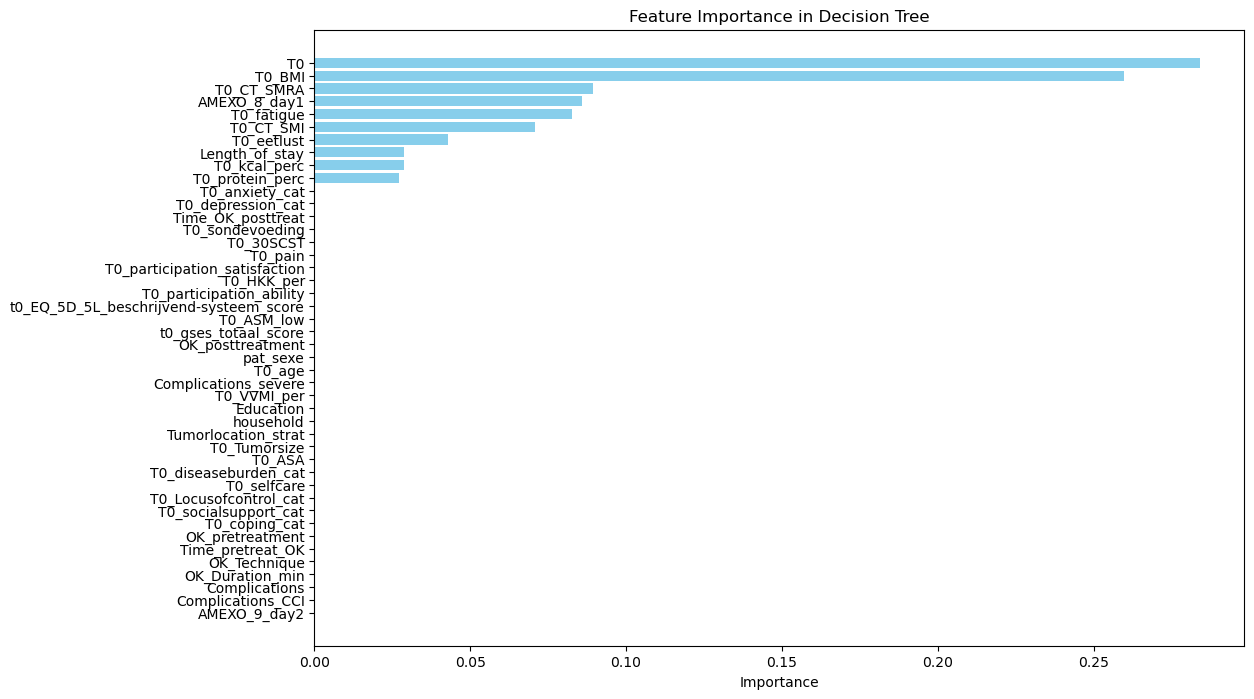

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'best_tree_model' is the trained Decision Tree model
# and 'X' is the DataFrame containing the features

# Extract feature importances from the Decision Tree model
feature_importances = best_tree_model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print the DataFrame with feature importances
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Decision Tree')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()


In [ ]:
from sklearn.inspection import permutation_importance

# Plot the Decision Tree with feature importance
plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=best_features_tree, class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()

# Calculate and plot feature importance for the Decision Tree
importances = tree_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances for Decision Tree")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), [best_features_tree[i] for i in indices], rotation=90)
plt.xlim([-1, len(indices)])
plt.show()

# Show info about the logistic regression model
log_reg.fit(X_train[best_features_log_reg], y_train)
y_test_pred = log_reg.predict(X_test[best_features_log_reg])

# Print coefficients of the logistic regression model
coefficients = pd.DataFrame(log_reg.coef_[0], index=best_features_log_reg, columns=['Coefficient'])
coefficients['Direction'] = coefficients['Coefficient'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
print("Logistic Regression Coefficients and Direction of Relationship:")
print(coefficients)

# Calculate and plot feature importance using permutation importance for Logistic Regression
result = permutation_importance(log_reg, X_test[best_features_log_reg], y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=[best_features_log_reg[i] for i in sorted_idx])
plt.title("Permutation Importances (test set) for Logistic Regression")
plt.show()

# Logistic Regression Model Formula
intercept = log_reg.intercept_[0]
formula_terms = [f"{coeff:.3f}*{feature}" for coeff, feature in zip(log_reg.coef_[0], best_features_log_reg)]
formula = f"log_odds = {intercept:.3f} + " + " + ".join(formula_terms)
print("Logistic Regression Model Formula:")
print(formula)


c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


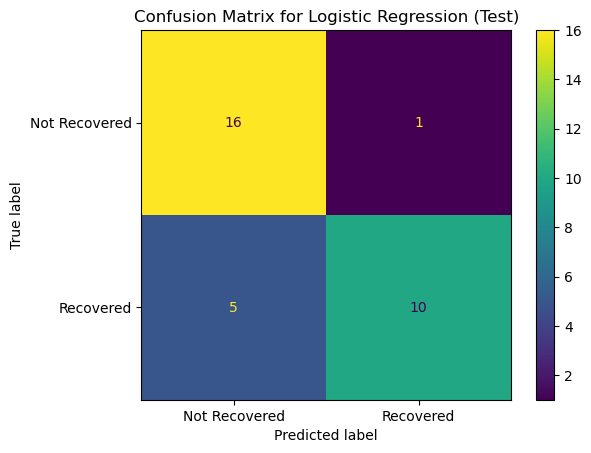

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


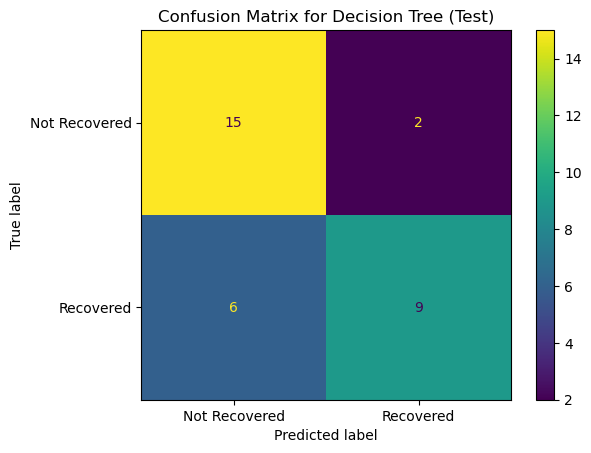

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


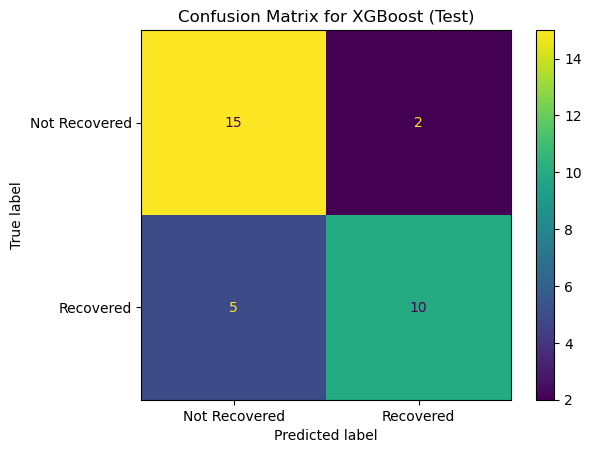

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


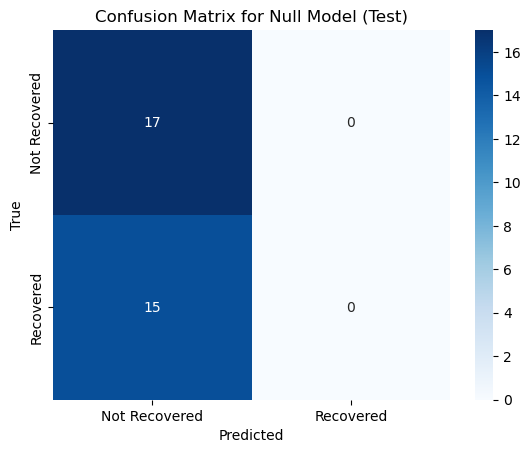

                 Model Dataset  Accuracy  Precision    Recall  Specificity  \
0  Logistic Regression    Test   0.81250   0.909091  0.666667     0.941176   
1        Decision Tree    Test   0.75000   0.818182  0.600000     0.882353   
2              XGBoost    Test   0.78125   0.833333  0.666667     0.882353   
3           Null Model    Test   0.53125   0.000000  0.000000     1.000000   

         F1  
0  0.769231  
1  0.692308  
2  0.740741  
3  0.000000  


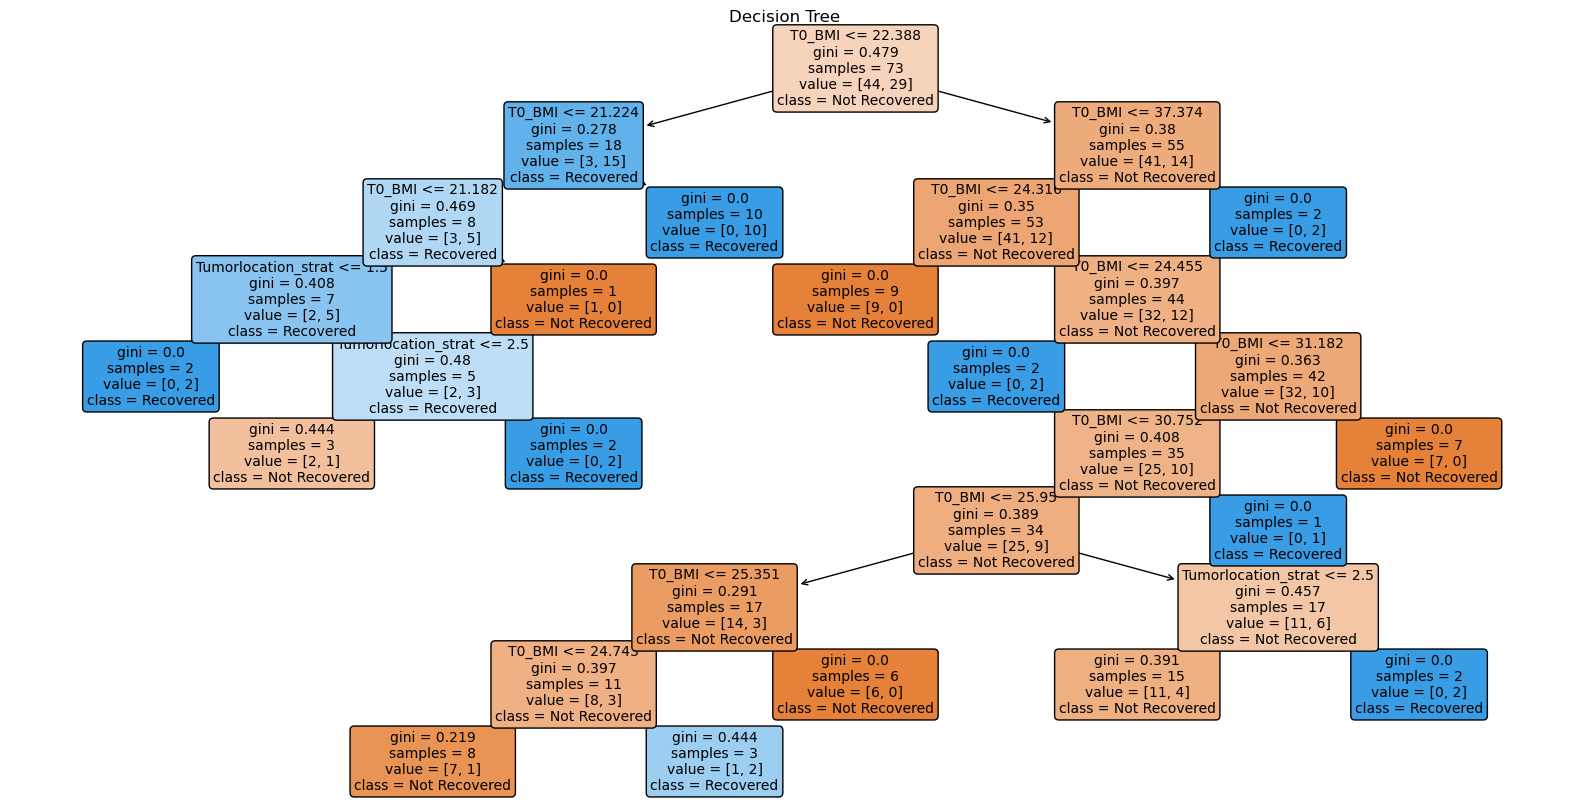

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_clean is already defined and clean

# Select the features and target variable
X = data_clean.drop(columns=['T5', 'T5_recovered'])
y = data_clean['T5_recovered']

# Maak een train/test split met 70% train en 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Functie om de metrics te berekenen
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, specificity, f1

# Forward feature selection function
def forward_feature_selection(model, X_train, y_train, X_test, y_test):
    initial_features = []
    best_features = []
    best_score = 0
    current_score = 0

    while True:
        scores = []
        for feature in X_train.columns:
            if feature in initial_features:
                continue
            selected_features = initial_features + [feature]
            model.fit(X_train[selected_features], y_train)
            y_pred = model.predict(X_test[selected_features])
            accuracy = accuracy_score(y_test, y_pred)
            scores.append((accuracy, feature))

        scores.sort(reverse=True)
        current_score, best_feature = scores[0]

        if current_score > best_score:
            best_score = current_score
            best_features.append(best_feature)
            initial_features.append(best_feature)
        else:
            break

    return best_features

# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
best_features_log_reg = forward_feature_selection(log_reg, X_train, y_train, X_test, y_test)

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=15)
best_features_tree = forward_feature_selection(tree_model, X_train, y_train, X_test, y_test)

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
best_features_xgb = forward_feature_selection(xgb_model, X_train, y_train, X_test, y_test)

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mode = y.mode()[0]
    def predict(self, X):
        return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train, y_train)

# Evaluate models
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Logistic Regression
log_reg.fit(X_train[best_features_log_reg], y_train)
y_test_pred = log_reg.predict(X_test[best_features_log_reg])
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Logistic Regression')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(log_reg, X_test[best_features_log_reg], y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Logistic Regression (Test)')
plt.show()

# Decision Tree
tree_model.fit(X_train[best_features_tree], y_train)
y_test_pred = tree_model.predict(X_test[best_features_tree])
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Decision Tree')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(tree_model, X_test[best_features_tree], y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Decision Tree (Test)')
plt.show()

# XGBoost
xgb_model.fit(X_train[best_features_xgb], y_train)
y_test_pred = xgb_model.predict(X_test[best_features_xgb])
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('XGBoost')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(xgb_model, X_test[best_features_xgb], y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for XGBoost (Test)')
plt.show()

# Null Model
y_test_pred = null_model.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Null Model')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix for Null Model (Test)')
ax.set_xticklabels(['Not Recovered', 'Recovered'])
ax.set_yticklabels(['Not Recovered', 'Recovered'])
plt.show()

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=best_features_tree, class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()

### Subset variabelen

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


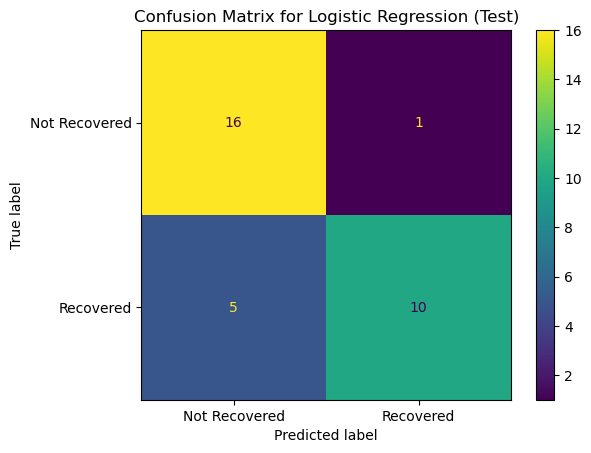

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


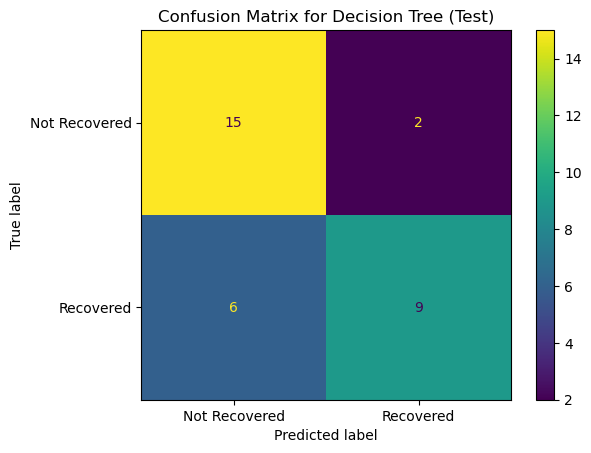

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


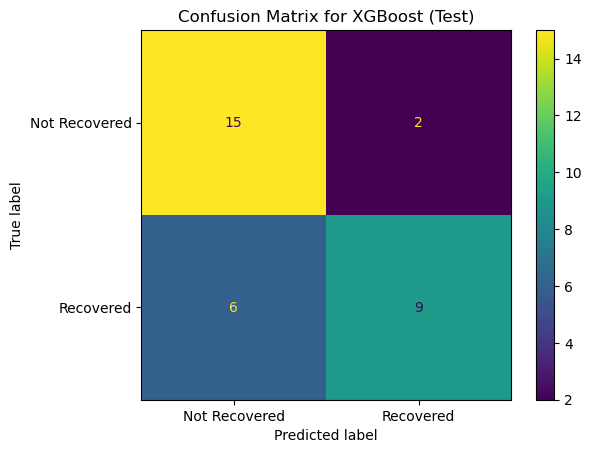

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


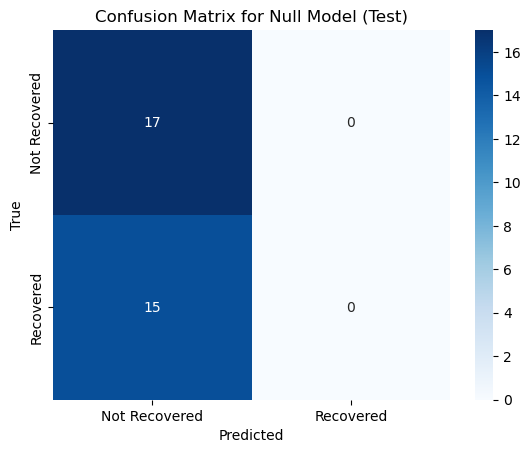

                 Model Dataset  Accuracy  Precision    Recall  Specificity  \
0  Logistic Regression    Test   0.81250   0.909091  0.666667     0.941176   
1        Decision Tree    Test   0.75000   0.818182  0.600000     0.882353   
2              XGBoost    Test   0.75000   0.818182  0.600000     0.882353   
3           Null Model    Test   0.53125   0.000000  0.000000     1.000000   

         F1  
0  0.769231  
1  0.692308  
2  0.692308  
3  0.000000  


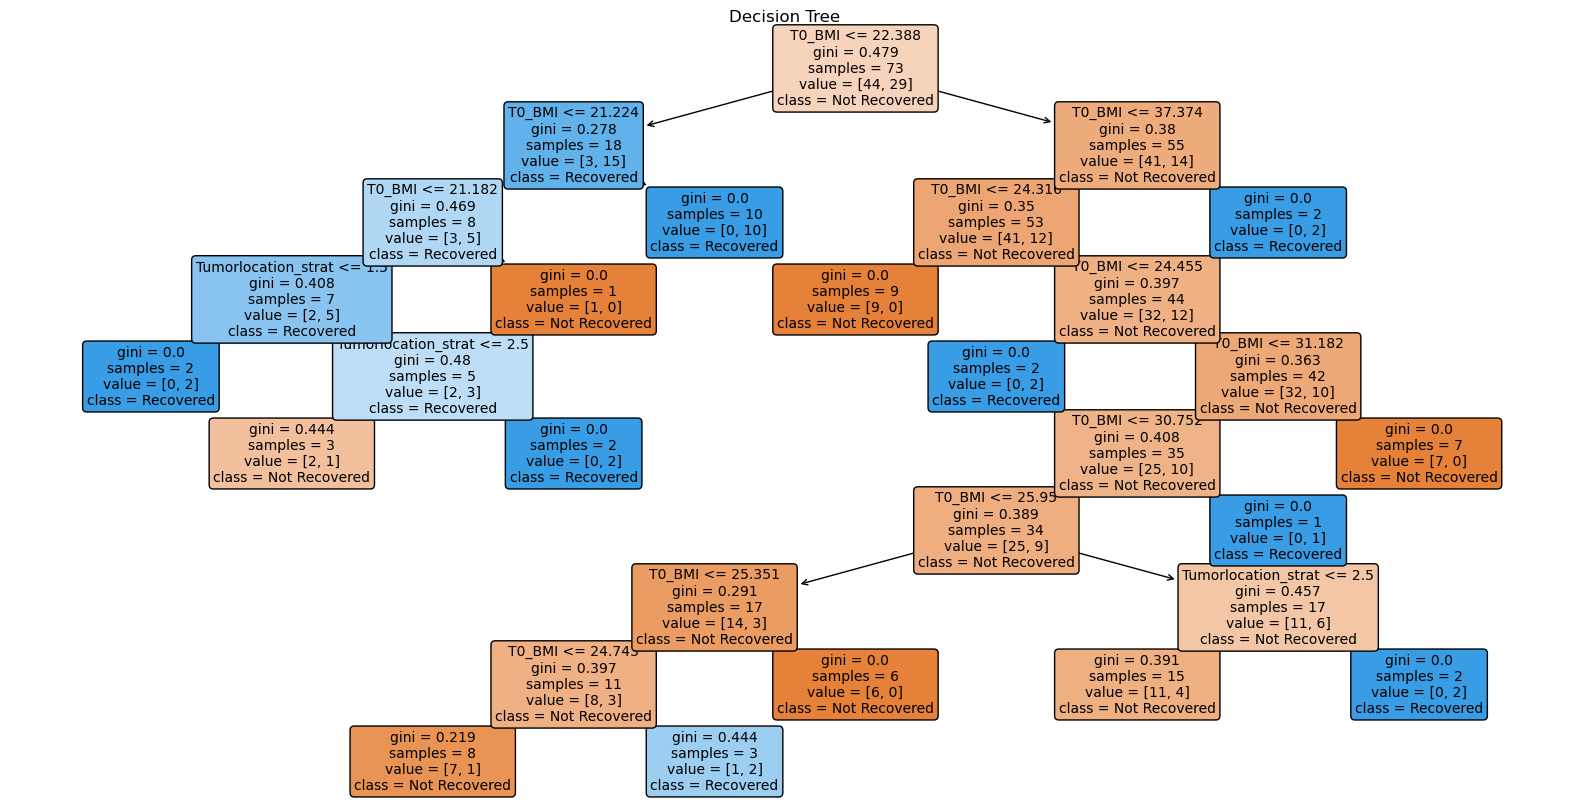

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_clean is already defined and clean
# Specify the subset of variables to use
variables_start = ['pat_sexe', 'T0_age', 'T0_BMI', 'Education', 'household',
       'Tumorlocation_strat', 'T0_Tumorsize', 'T0_ASA', 'OK_pretreatment', 'Time_pretreat_OK', 'OK_Technique',
       'OK_Duration_min', 'Complications', 'Complications_CCI', 'Complications_severe', 'AMEXO_8_day1', 'AMEXO_9_day2',
       'Length_of_stay', 'OK_posttreatment', 'Time_OK_posttreat', 'T0_sondevoeding', 'T0_pain', 'T0_fatigue', 
       'T0_HKK_per', 'T0_kcal_perc', 'T0', 'T5', 'T5_recovered']

# Select the features and target variable
X = data_clean[variables_start].drop(columns=['T5', 'T5_recovered'])
y = data_clean['T5_recovered']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, specificity, f1

# Penalty function for the number of features
def feature_penalty(n_features, penalty_factor=0.01):
    return penalty_factor * n_features

# Forward feature selection function with penalty
def forward_feature_selection(model, X_train, y_train, X_test, y_test):
    initial_features = []
    best_features = []
    best_score = -np.inf  # Initialize to a very low value
    current_score = 0

    while True:
        scores = []
        for feature in X_train.columns:
            if feature in initial_features:
                continue
            selected_features = initial_features + [feature]
            model.fit(X_train[selected_features], y_train)
            y_pred = model.predict(X_test[selected_features])
            accuracy = accuracy_score(y_test, y_pred)
            penalty = feature_penalty(len(selected_features))
            score = accuracy - penalty
            scores.append((score, feature))

        scores.sort(reverse=True)
        current_score, best_feature = scores[0]

        if current_score > best_score:
            best_score = current_score
            best_features.append(best_feature)
            initial_features.append(best_feature)
        else:
            break

    return best_features

# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
best_features_log_reg = forward_feature_selection(log_reg, X_train, y_train, X_test, y_test)

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=15, ccp_alpha=0.01)
best_features_tree = forward_feature_selection(tree_model, X_train, y_train, X_test, y_test)

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
best_features_xgb = forward_feature_selection(xgb_model, X_train, y_train, X_test, y_test)

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mode = y.mode()[0]
    def predict(self, X):
        return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train, y_train)

# Evaluate models
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Logistic Regression
log_reg.fit(X_train[best_features_log_reg], y_train)
y_test_pred = log_reg.predict(X_test[best_features_log_reg])
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Logistic Regression')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(log_reg, X_test[best_features_log_reg], y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Logistic Regression (Test)')
plt.show()

# Decision Tree
tree_model.fit(X_train[best_features_tree], y_train)
y_test_pred = tree_model.predict(X_test[best_features_tree])
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Decision Tree')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(tree_model, X_test[best_features_tree], y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Decision Tree (Test)')
plt.show()

# XGBoost
xgb_model.fit(X_train[best_features_xgb], y_train)
y_test_pred = xgb_model.predict(X_test[best_features_xgb])
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('XGBoost')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(xgb_model, X_test[best_features_xgb], y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for XGBoost (Test)')
plt.show()

# Null Model
y_test_pred = null_model.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Null Model')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix for Null Model (Test)')
ax.set_xticklabels(['Not Recovered', 'Recovered'])
ax.set_yticklabels(['Not Recovered', 'Recovered'])
plt.show()

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=best_features_tree, class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()


#### K-Fold Cross Validation - train/validation set
- Dataset wordt gesplitst in trainings- en testsets.
- Er wordt een 5-voudige cross-validatie uitgevoerd met hyperparameter tuning voor zowel Lasso Regression als XGBoost Regression om de beste modelconfiguratie te vinden.
- Het beste model wordt opnieuw getraind op de volledige trainingsset en geëvalueerd op de testset, waarbij de prestaties worden gemeten met MAE, RMSE en R².
- Een null model, dat het gemiddelde van de trainingsset voorspelt, wordt gebruikt als benchmark om de prestaties van de regressiemodellen te vergelijken.

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming data_clean is already defined and clean

# Select the features and target variable
X = data_clean.drop(columns=['T5', 'T5_recovered'])
y = data_clean['T5_recovered']

# Maak een train/test split met 70% train en 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
log_reg_params = {'C': [0.01, 0.1, 1, 10, 100]}

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_params = {'max_depth': [3, 5, 7, 10], 'max_leaf_nodes': [5, 10, 20, 30]}

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV
log_reg_cv = GridSearchCV(log_reg, log_reg_params, cv=kf, scoring='accuracy')
log_reg_cv.fit(X_train, y_train)

tree_cv = GridSearchCV(tree_model, tree_params, cv=kf, scoring='accuracy')
tree_cv.fit(X_train, y_train)

xgb_cv = GridSearchCV(xgb_model, xgb_params, cv=kf, scoring='accuracy')
xgb_cv.fit(X_train, y_train)

# Best estimators
best_log_reg = log_reg_cv.best_estimator_
best_tree = tree_cv.best_estimator_
best_xgb = xgb_cv.best_estimator_


# Functie om de metrics te berekenen
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, specificity, f1

# Train the best models on the full training set
best_log_reg.fit(X_train, y_train)
best_tree.fit(X_train, y_train)
best_xgb.fit(X_train, y_train)

# Evaluate models
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Logistic Regression
y_test_pred = best_log_reg.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Logistic Regression')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(best_log_reg, X_test, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Logistic Regression (Test)')
plt.show()

# Decision Tree
y_test_pred = best_tree.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Decision Tree')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(best_tree, X_test, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Decision Tree (Test)')
plt.show()

# XGBoost
y_test_pred = best_xgb.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('XGBoost')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(best_xgb, X_test, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for XGBoost (Test)')
plt.show()

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mode = y.mode()[0]
    def predict(self, X):
        return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train, y_train)

# Null Model Evaluation
y_test_pred = null_model.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Null Model')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix for Null Model (Test)')
ax.set_xticklabels(['Not Recovered', 'Recovered'])
ax.set_yticklabels(['Not Recovered', 'Recovered'])
plt.show()


# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(best_tree, feature_names=X.columns, class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()




In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_clean is already defined and clean

# Select the features and target variable
X = data_clean.drop(columns=['T5', 'T5_recovered'])
y = data_clean['T5_recovered']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Functie om de metrics te berekenen
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, specificity, f1

# Forward feature selection function
def forward_feature_selection(model, X_train, y_train, X_val, y_val):
    initial_features = []
    best_features = []
    best_score = 0
    current_score = 0

    while True:
        scores = []
        for feature in X_train.columns:
            if feature in initial_features:
                continue
            selected_features = initial_features + [feature]
            model.fit(X_train[selected_features], y_train)
            y_pred = model.predict(X_val[selected_features])
            accuracy = accuracy_score(y_val, y_pred)
            scores.append((accuracy, feature))

        scores.sort(reverse=True)
        current_score, best_feature = scores[0]

        if current_score > best_score:
            best_score = current_score
            best_features.append(best_feature)
            initial_features.append(best_feature)
        else:
            break

    return best_features

# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
best_features_log_reg = forward_feature_selection(log_reg, X_train, y_train, X_val, y_val)

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=5)
best_features_tree = forward_feature_selection(tree_model, X_train, y_train, X_val, y_val)

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
best_features_xgb = forward_feature_selection(xgb_model, X_train, y_train, X_val, y_val)

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mode = y.mode()[0]
    def predict(self, X):
        return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train, y_train)

# Evaluate models
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Logistic Regression
log_reg.fit(X_train[best_features_log_reg], y_train)
y_test_pred = log_reg.predict(X_test[best_features_log_reg])
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Logistic Regression')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(log_reg, X_test[best_features_log_reg], y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Logistic Regression (Test)')
plt.show()

# Decision Tree
tree_model.fit(X_train[best_features_tree], y_train)
y_test_pred = tree_model.predict(X_test[best_features_tree])
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Decision Tree')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(tree_model, X_test[best_features_tree], y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Decision Tree (Test)')
plt.show()

# XGBoost
xgb_model.fit(X_train[best_features_xgb], y_train)
y_test_pred = xgb_model.predict(X_test[best_features_xgb])
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('XGBoost')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(xgb_model, X_test[best_features_xgb], y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for XGBoost (Test)')
plt.show()

# Null Model
y_test_pred = null_model.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Null Model')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix for Null Model (Test)')
ax.set_xticklabels(['Not Recovered', 'Recovered'])
ax.set_yticklabels(['Not Recovered', 'Recovered'])
plt.show()

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=best_features_tree, class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()


### Dimensionality Reduction - PCA
Leidt tot een significante prestatiereductie

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_clean is already defined and clean

# Select the features and target variable
X = data_clean.drop(columns=['T5', 'T5_recovered'])
y = data_clean['T5_recovered']

# Perform PCA on the input features to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, specificity, f1

# Initialize models
log_reg = LogisticRegression(max_iter=10000)
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=5)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Apply RFE to select the most important features
rfe_log_reg = RFE(log_reg, n_features_to_select=10)
X_train_rfe_log_reg = rfe_log_reg.fit_transform(X_train, y_train)
X_test_rfe_log_reg = rfe_log_reg.transform(X_test)

rfe_tree = RFE(tree_model, n_features_to_select=10)
X_train_rfe_tree = rfe_tree.fit_transform(X_train, y_train)
X_test_rfe_tree = rfe_tree.transform(X_test)

rfe_xgb = RFE(xgb_model, n_features_to_select=10)
X_train_rfe_xgb = rfe_xgb.fit_transform(X_train, y_train)
X_test_rfe_xgb = rfe_xgb.transform(X_test)

# Evaluate models
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Logistic Regression
log_reg.fit(X_train_rfe_log_reg, y_train)
y_test_pred = log_reg.predict(X_test_rfe_log_reg)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Logistic Regression')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(log_reg, X_test_rfe_log_reg, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Logistic Regression (Test)')
plt.show()

# Decision Tree
tree_model.fit(X_train_rfe_tree, y_train)
y_test_pred = tree_model.predict(X_test_rfe_tree)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Decision Tree')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(tree_model, X_test_rfe_tree, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Decision Tree (Test)')
plt.show()

# XGBoost
xgb_model.fit(X_train_rfe_xgb, y_train)
y_test_pred = xgb_model.predict(X_test_rfe_xgb)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('XGBoost')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(xgb_model, X_test_rfe_xgb, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for XGBoost (Test)')
plt.show()

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mode = y.mode()[0]
    def predict(self, X):
        return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train, y_train)

y_test_pred = null_model.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Null Model')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix for Null Model (Test)')
ax.set_xticklabels(['Not Recovered', 'Recovered'])
ax.set_yticklabels(['Not Recovered', 'Recovered'])
plt.show()

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
# Since RFE was applied to PCA components, we can just display the component indices
plot_tree(tree_model, feature_names=[f'PCA{i+1}' for i in range(X_train_rfe_tree.shape[1])], class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_clean is already defined and clean

# Select the features and target variable
X = data_clean.drop(columns=['T5', 'T5_recovered'])
y = data_clean['T5_recovered']

# Split the data into training and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)

# Perform PCA on the training set and apply the transformation to the validation and test sets
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, specificity, f1

# Initialize models
log_reg = LogisticRegression(max_iter=10000)
tree_model = DecisionTreeClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Hyperparameter tuning using GridSearchCV with k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression hyperparameters
log_reg_params = {'C': [0.01, 0.1, 1, 10, 100]}
log_reg_cv = GridSearchCV(log_reg, log_reg_params, cv=kf, scoring='accuracy')
log_reg_cv.fit(X_train_pca, y_train)
best_log_reg = log_reg_cv.best_estimator_

# Decision Tree hyperparameters
tree_params = {'max_depth': [3, 5, 7, 10], 'max_leaf_nodes': [5, 10, 20, 30]}
tree_cv = GridSearchCV(tree_model, tree_params, cv=kf, scoring='accuracy')
tree_cv.fit(X_train_pca, y_train)
best_tree = tree_cv.best_estimator_

# XGBoost hyperparameters
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
xgb_cv = GridSearchCV(xgb_model, xgb_params, cv=kf, scoring='accuracy')
xgb_cv.fit(X_train_pca, y_train)
best_xgb = xgb_cv.best_estimator_

# Apply RFE to select the most important features
rfe_log_reg = RFE(best_log_reg, n_features_to_select=10)
X_train_rfe_log_reg = rfe_log_reg.fit_transform(X_train_pca, y_train)
X_val_rfe_log_reg = rfe_log_reg.transform(X_val_pca)
X_test_rfe_log_reg = rfe_log_reg.transform(X_test_pca)

rfe_tree = RFE(best_tree, n_features_to_select=10)
X_train_rfe_tree = rfe_tree.fit_transform(X_train_pca, y_train)
X_val_rfe_tree = rfe_tree.transform(X_val_pca)
X_test_rfe_tree = rfe_tree.transform(X_test_pca)

rfe_xgb = RFE(best_xgb, n_features_to_select=10)
X_train_rfe_xgb = rfe_xgb.fit_transform(X_train_pca, y_train)
X_val_rfe_xgb = rfe_xgb.transform(X_val_pca)
X_test_rfe_xgb = rfe_xgb.transform(X_test_pca)

# Train the best models using the selected features
best_log_reg.fit(X_train_rfe_log_reg, y_train)
best_tree.fit(X_train_rfe_tree, y_train)
best_xgb.fit(X_train_rfe_xgb, y_train)

# Evaluate models on the test set
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Logistic Regression
y_test_pred = best_log_reg.predict(X_test_rfe_log_reg)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Logistic Regression')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(best_log_reg, X_test_rfe_log_reg, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Logistic Regression (Test)')
plt.show()

# Decision Tree
y_test_pred = best_tree.predict(X_test_rfe_tree)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Decision Tree')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(best_tree, X_test_rfe_tree, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Decision Tree (Test)')
plt.show()

# XGBoost
y_test_pred = best_xgb.predict(X_test_rfe_xgb)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('XGBoost')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(best_xgb, X_test_rfe_xgb, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for XGBoost (Test)')
plt.show()

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mode = y.mode()[0]
    def predict(self, X):
        return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train_pca, y_train)

y_test_pred = null_model.predict(X_test_pca)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Null Model')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix for Null Model (Test)')
ax.set_xticklabels(['Not Recovered', 'Recovered'])
ax.set_yticklabels(['Not Recovered', 'Recovered'])
plt.show()

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
# Since RFE was applied to PCA components, we can just display the component indices
plot_tree(best_tree, feature_names=[f'PCA{i+1}' for i in range(X_train_rfe_tree.shape[1])], class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()


In [ ]:
################## Duurt 8 minunten ##########################

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_clean is already defined and clean

# Select the features and target variable
X = data_clean.drop(columns=['T5', 'T5_recovered'])
y = data_clean['T5_recovered']

# Split the data into training and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, specificity, f1

# Initialize models
log_reg = LogisticRegression(max_iter=10000)
tree_model = DecisionTreeClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create pipelines with PCA and model
pipe_log_reg = Pipeline([('pca', PCA()), ('log_reg', log_reg)])
pipe_tree = Pipeline([('pca', PCA()), ('tree', tree_model)])
pipe_xgb = Pipeline([('pca', PCA()), ('xgb', xgb_model)])

# Hyperparameter tuning using GridSearchCV with k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression hyperparameters including PCA n_components
log_reg_params = {
    'pca__n_components': [5, 10, 15, 20, 25, 30],
    'log_reg__C': [0.01, 0.1, 1, 10, 100]
}
log_reg_cv = GridSearchCV(pipe_log_reg, log_reg_params, cv=kf, scoring='accuracy')
log_reg_cv.fit(X_train, y_train)
best_log_reg = log_reg_cv.best_estimator_

# Decision Tree hyperparameters including PCA n_components
tree_params = {
    'pca__n_components': [5, 10, 15, 20, 25, 30],
    'tree__max_depth': [3, 5, 7, 10],
    'tree__max_leaf_nodes': [5, 10, 20, 30]
}
tree_cv = GridSearchCV(pipe_tree, tree_params, cv=kf, scoring='accuracy')
tree_cv.fit(X_train, y_train)
best_tree = tree_cv.best_estimator_

# XGBoost hyperparameters including PCA n_components
xgb_params = {
    'pca__n_components': [5, 10, 15, 20, 25, 30],
    'xgb__n_estimators': [100, 200, 300],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9]
}
xgb_cv = GridSearchCV(pipe_xgb, xgb_params, cv=kf, scoring='accuracy')
xgb_cv.fit(X_train, y_train)
best_xgb = xgb_cv.best_estimator_

# Apply RFE to select the most important features
rfe_log_reg = RFE(best_log_reg.named_steps['log_reg'], n_features_to_select=10)
X_train_rfe_log_reg = rfe_log_reg.fit_transform(best_log_reg.named_steps['pca'].transform(X_train), y_train)
X_val_rfe_log_reg = rfe_log_reg.transform(best_log_reg.named_steps['pca'].transform(X_val))
X_test_rfe_log_reg = rfe_log_reg.transform(best_log_reg.named_steps['pca'].transform(X_test))

rfe_tree = RFE(best_tree.named_steps['tree'], n_features_to_select=10)
X_train_rfe_tree = rfe_tree.fit_transform(best_tree.named_steps['pca'].transform(X_train), y_train)
X_val_rfe_tree = rfe_tree.transform(best_tree.named_steps['pca'].transform(X_val))
X_test_rfe_tree = rfe_tree.transform(best_tree.named_steps['pca'].transform(X_test))

rfe_xgb = RFE(best_xgb.named_steps['xgb'], n_features_to_select=10)
X_train_rfe_xgb = rfe_xgb.fit_transform(best_xgb.named_steps['pca'].transform(X_train), y_train)
X_val_rfe_xgb = rfe_xgb.transform(best_xgb.named_steps['pca'].transform(X_val))
X_test_rfe_xgb = rfe_xgb.transform(best_xgb.named_steps['pca'].transform(X_test))

# Train the best models using the selected features
best_log_reg.named_steps['log_reg'].fit(X_train_rfe_log_reg, y_train)
best_tree.named_steps['tree'].fit(X_train_rfe_tree, y_train)
best_xgb.named_steps['xgb'].fit(X_train_rfe_xgb, y_train)

# Evaluate models on the test set
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Logistic Regression
y_test_pred = best_log_reg.named_steps['log_reg'].predict(X_test_rfe_log_reg)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Logistic Regression')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(best_log_reg.named_steps['log_reg'], X_test_rfe_log_reg, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Logistic Regression (Test)')
plt.show()

# Decision Tree
y_test_pred = best_tree.named_steps['tree'].predict(X_test_rfe_tree)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Decision Tree')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(best_tree.named_steps['tree'], X_test_rfe_tree, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Decision Tree (Test)')
plt.show()

# XGBoost
y_test_pred = best_xgb.named_steps['xgb'].predict(X_test_rfe_xgb)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('XGBoost')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(best_xgb.named_steps['xgb'], X_test_rfe_xgb, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for XGBoost (Test)')
plt.show()

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mode = y.mode()[0]
    def predict(self, X):
        return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train, y_train)

y_test_pred = null_model.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Null Model')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix for Null Model (Test)')
ax.set_xticklabels(['Not Recovered', 'Recovered'])
ax.set_yticklabels(['Not Recovered', 'Recovered'])
plt.show()

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
# Since RFE was applied to PCA components, we can just display the component indices
plot_tree(best_tree.named_steps['tree'], feature_names=[f'PCA{i+1}' for i in range(X_train_rfe_tree.shape[1])], class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()
